In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
def import_data():
    X_train = pd.read_csv('./train/X_train.csv')
    X_test = pd.read_csv('./test/X_test.csv')
    y_train = pd.read_csv('./train/y_train.csv')
    y_test = pd.read_csv('./test/y_test.csv')
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = import_data()

In [8]:
y_train.value_counts()

0            
No-Recidivism    2997
Non-Violent       649
Violent           148
dtype: int64

In [156]:
X_train.shape

(3794, 29)

In [157]:
X_train.head(5).T

,0,1,2,3,4
id,2677,548,4483,9476,199
name,nicholas staggewise,newton smith,terrance irvin,jaimie peterson,ritesh sukhlall
first,nicholas,newton,terrance,jaimie,ritesh
last,staggewise,smith,irvin,peterson,sukhlall
sex,Male,Male,Male,Female,Male
date_of_birth,1994-02-28,1995-01-28,1984-04-10,1986-01-02,1987-05-12
age,22,21,32,30,28
age_group,Less than 25,Less than 25,25 - 45,25 - 45,25 - 45
race,Caucasian,African-American,African-American,African-American,Caucasian
juv_fel_count,0,0,0,0,0


In [10]:
X_train['c_charge_desc'].unique()

array(['arrest case no charge', 'Grand Theft in the 3rd Degree',
       'Felony Driving While Lic Suspd', 'Robbery W/Firearm', 'Battery',
       'Possession of Hydrocodone', 'Burglary With Assault/battery',
       'Possession of Cocaine', 'Possess Cannabis/20 Grams Or Less',
       'Susp Drivers Lic 1st Offense', 'Uttering Forged Credit Card',
       'Aggrav Battery w/Deadly Weapon', 'Purchase Of Cocaine',
       'Agg Battery Grt/Bod/Harm', 'Burglary Unoccupied Dwelling',
       'Aggravated Assault w/Firearm', 'Disorderly Intoxication',
       'Possession Of Amphetamine', 'Manufacture Cannabis',
       'DUI- Enhanced', 'Opert With Susp DL 2nd Offens',
       'Possession Of Alprazolam', 'Deliver Cannabis', 'Child Abuse',
       'Grand Theft (Motor Vehicle)', 'Retail Theft $300 1st Offense',
       'Driving Under The Influence', 'Leave Acc/Attend Veh/More $50',
       'Felony Petit Theft', 'Burglary Dwelling Occupied',
       'Aggravated Assault W/Dead Weap', 'Possession of Cannabis',
  

In [158]:
drop = ['id', 'name', 'first', 'last',  'date_of_birth', 'age',
       'race', 'c_jail_in', 'c_jail_out', 'c_offense_date', 'c_arrest_date',
       'r_jail_in', 'r_jail_out',
       'type_of_assessment', 'screening_date', 'v_type_of_assessment',
       'v_screening_date', 'in_custody', 'out_custody', 'start']

multi_cat =  ['age_group','c_charge_desc']
binary_cat = ['sex','c_charge_degree',]
continuous = ['juv_fel_count', 'juv_misd_count','juv_other_count', 'priors_count',
              'days_b_screening_arrest','start']              

In [159]:
X_train.drop(drop,inplace=True,axis=1)
X_test.drop(drop,inplace=True,axis=1)

In [160]:
X_train.isnull().sum()

sex                          0
age_group                    0
juv_fel_count                0
juv_misd_count               0
juv_other_count              0
priors_count                 0
days_b_screening_arrest    215
c_charge_degree              0
c_charge_desc               12
dtype: int64

In [161]:
X_test.isnull().sum()

sex                         0
age_group                   0
juv_fel_count               0
juv_misd_count              0
juv_other_count             0
priors_count                0
days_b_screening_arrest    53
c_charge_degree             0
c_charge_desc               5
dtype: int64

In [162]:
mean = X_train['days_b_screening_arrest'].mean()
X_train['days_b_screening_arrest'].fillna(mean,inplace=True)
X_test['days_b_screening_arrest'].fillna(mean,inplace=True)

In [163]:
y_train_to_drop = X_train[X_train['c_charge_desc'].isnull()].index
y_test_to_drop = X_test[X_test['c_charge_desc'].isnull()].index

In [164]:
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.drop(y_train_to_drop,axis=0)
y_test = y_test.drop(y_test_to_drop,axis=0)

In [165]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [166]:
oh_enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
label_enc=LabelEncoder()
scaler = StandardScaler()

In [167]:
col_trans = ColumnTransformer([('categorical', oh_enc, multi_cat+binary_cat)], 
                              remainder='passthrough',sparse_threshold=1)

In [168]:
X_train = pd.DataFrame(col_trans.fit_transform(X_train),columns = col_trans.get_feature_names())
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
y_train = label_enc.fit_transform(y_train.iloc[:,0])

In [169]:
X_test = pd.DataFrame(col_trans.transform(X_test),columns = col_trans.get_feature_names())
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)
y_test = label_enc.transform(y_test.iloc[:,0])

In [170]:
model = RandomForestClassifier(n_estimators=200)

In [184]:
model.fit(X_train,y_train)
preds = model.predict(X_test)
probs = model.predict_proba(X_test)
model.score(X_test,y_test)

0.7616525423728814

In [180]:
from sklearn.metrics import classification_report
import scikitplot as skplt

In [181]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       749
           1       0.36      0.23      0.28       168
           2       0.10      0.04      0.05        27

    accuracy                           0.76       944
   macro avg       0.43      0.39      0.40       944
weighted avg       0.72      0.76      0.73       944



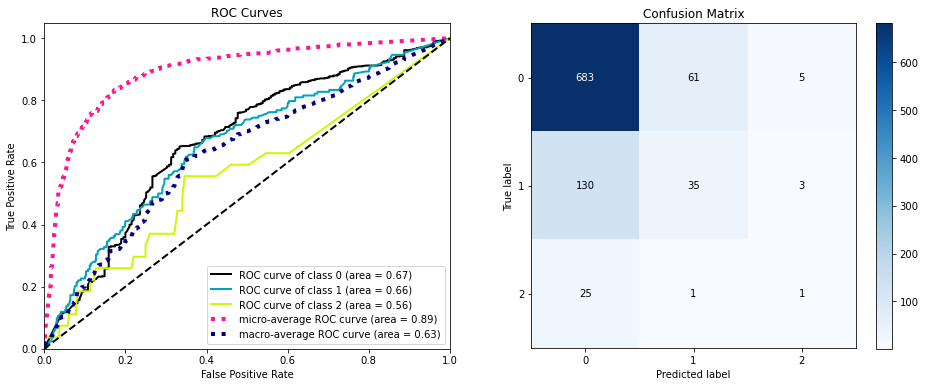

In [197]:
fig,ax=plt.subplots(ncols=2,figsize = (16,6))
skplt.metrics.plot_confusion_matrix(y_test, preds, ax = ax[1])
skplt.metrics.plot_roc(y_test,probs,ax=ax[0])
plt.show()

In [15]:
y_test.value_counts(normalize=True)

0            
No-Recidivism    0.791359
Non-Violent      0.179136
Violent          0.029505
dtype: float64

In [14]:
y_train.value_counts()

0            
No-Recidivism    2997
Non-Violent       649
Violent           148
dtype: int64

In [ ]:
### oversampling for y imbalance
### oversampling for sensitive data balance
### link between charges and y